## 多项式回归


$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将*特征*从$x^i$调整为$\frac{x^i}{i!}$的原因，这样可以避免对于很大的$i$得到特别大的指数值。我们将为训练集和测试集各合成100个样本。

In [1]:
import math
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [2]:
max_degree = 20 # 多项式最大阶数
n_train, n_test = 100, 100 # 训练集和测试集的大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n) = (n - 1)!

labels = poly_features @ true_w
labels += np.random.normal(scale=0.1, size=labels.shape) # 噪声

In [3]:
features.shape, poly_features.shape, labels.shape

((200, 1), (200, 20), (200,))

In [4]:
# numpy ndarray to tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.3098],
         [-0.6878]]),
 tensor([[ 1.0000e+00, -3.0981e-01,  4.7992e-02, -4.9562e-03,  3.8388e-04,
          -2.3786e-05,  1.2282e-06, -5.4360e-08,  2.1052e-09, -7.2469e-11,
           2.2452e-12, -6.3235e-14,  1.6326e-15, -3.8908e-17,  8.6102e-19,
          -1.7784e-20,  3.4435e-22, -6.2756e-24,  1.0801e-25, -1.7613e-27],
         [ 1.0000e+00, -6.8784e-01,  2.3657e-01, -5.4240e-02,  9.3272e-03,
          -1.2831e-03,  1.4710e-04, -1.4454e-05,  1.2428e-06, -9.4984e-08,
           6.5334e-09, -4.0854e-10,  2.3418e-11, -1.2391e-12,  6.0877e-14,
          -2.7916e-15,  1.2001e-16, -4.8559e-18,  1.8556e-19, -6.7177e-21]]),
 tensor([4.4156, 3.0711]))

### 损失函数

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2) # 损失总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

### 模型训练


In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_features.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), 
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), 
                               batch_size, is_train=False)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), 
                                     evaluate_loss(net, test_iter, loss)))
    print('weight: ', net[0].weight.data.numpy())

weight:  [[ 5.0178146  1.2417736 -3.4158342  5.5187426]]


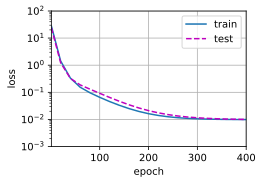

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
      labels[:n_train], labels[n_train:])

## 欠拟合

weight:  [[3.3593714 4.1409163]]


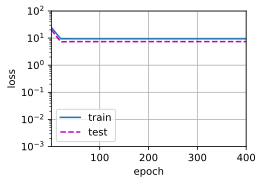

In [8]:
# 选择多项式的前两个维度，即使用线性模型拟合多项式
train(poly_features[:n_train, :2], poly_features[n_train:,:2],
      labels[:n_train], labels[n_train:])

## 过拟合

weight:  [[ 4.987831    1.303804   -3.273787    5.169033   -0.37842843  0.9311125
   0.1709643   0.09038764 -0.15404338 -0.13234642 -0.13992068 -0.20288692
   0.19139655  0.09766169  0.03691547  0.1489431   0.17118555  0.11500673
  -0.18574007  0.19577187]]


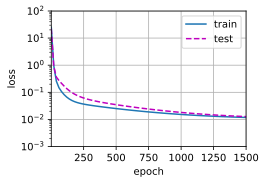

In [9]:
# 选择多项式的所有维度
train(poly_features[:n_train,:], poly_features[n_train:,:],
      labels[:n_train], labels[n_train:], num_epochs=1500)